# End-to-end trainig

In [1]:
# BAND = "r"
# NON_EXTENDED_ONLY = True

N_SRC = 10
BATCH_SIZE = 32
N_LCS = 1_000_000

DP1_ROOT = "../../data/dp1"
LSDB_WORKERS = 8
DEVICE = "mps"

PLOT_ON_TEST_SET = False
PLOT_MAGS = [18, 21, 25]

Dask Dashboard Link: http://127.0.0.1:8787/status


/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'F', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contigu

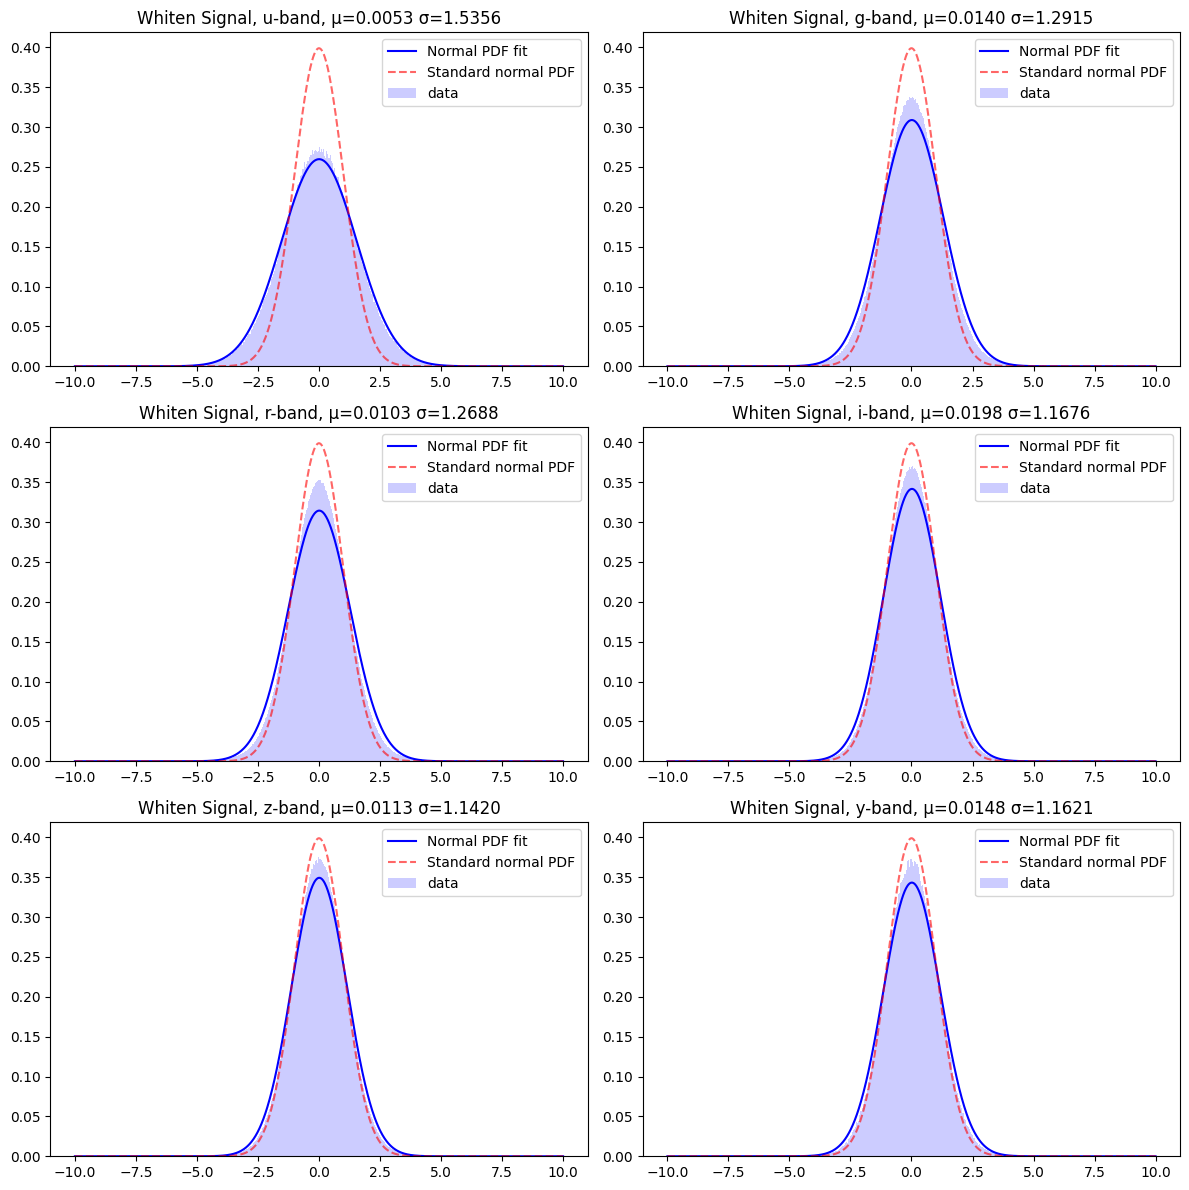

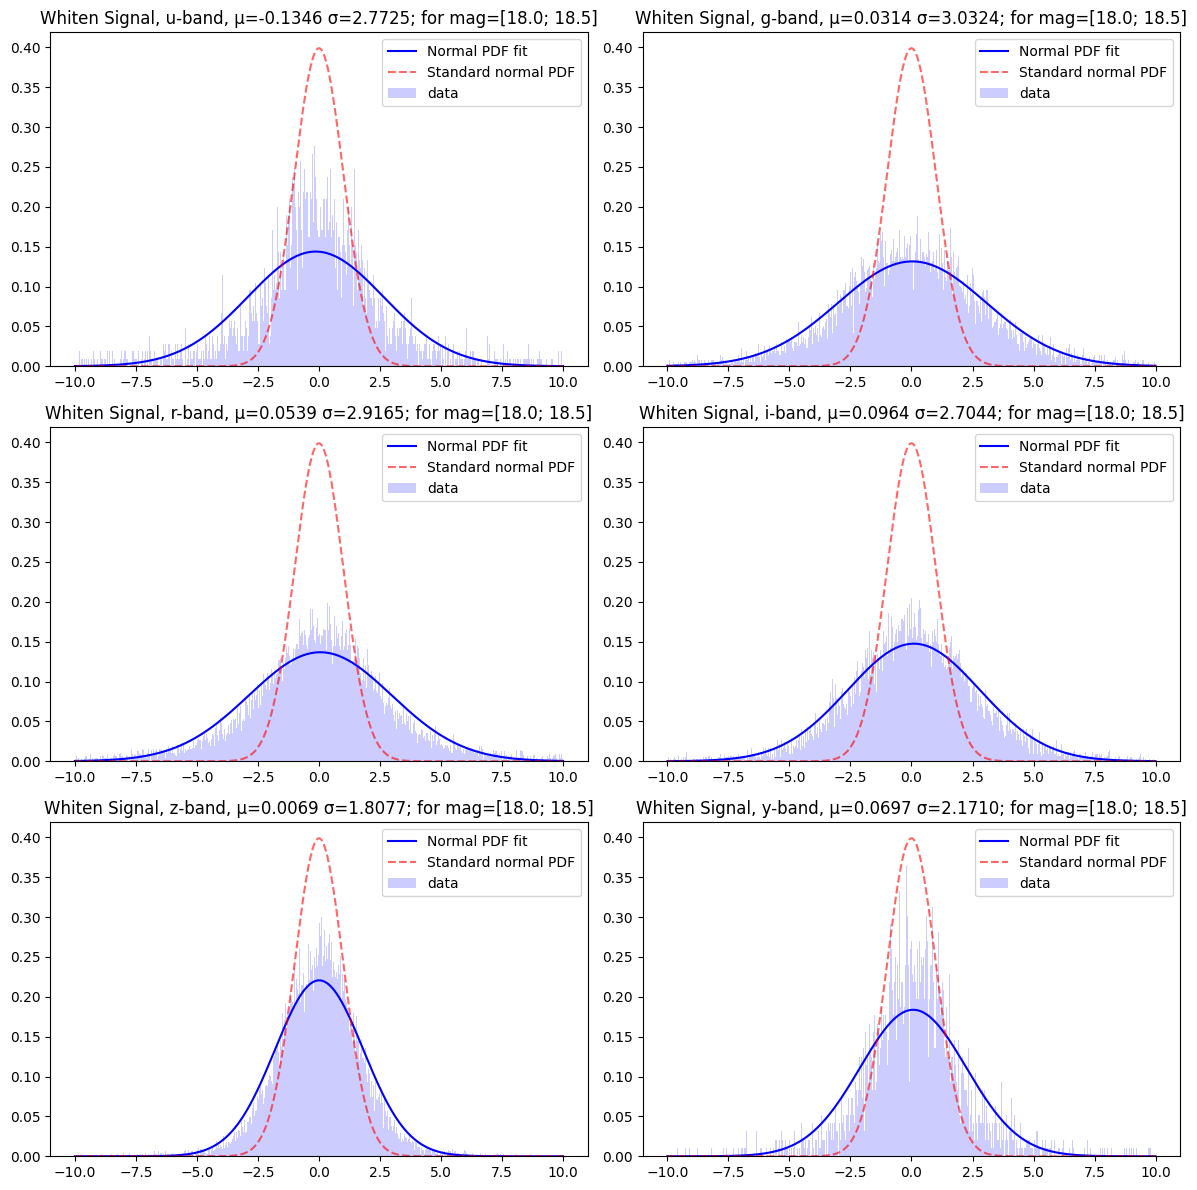

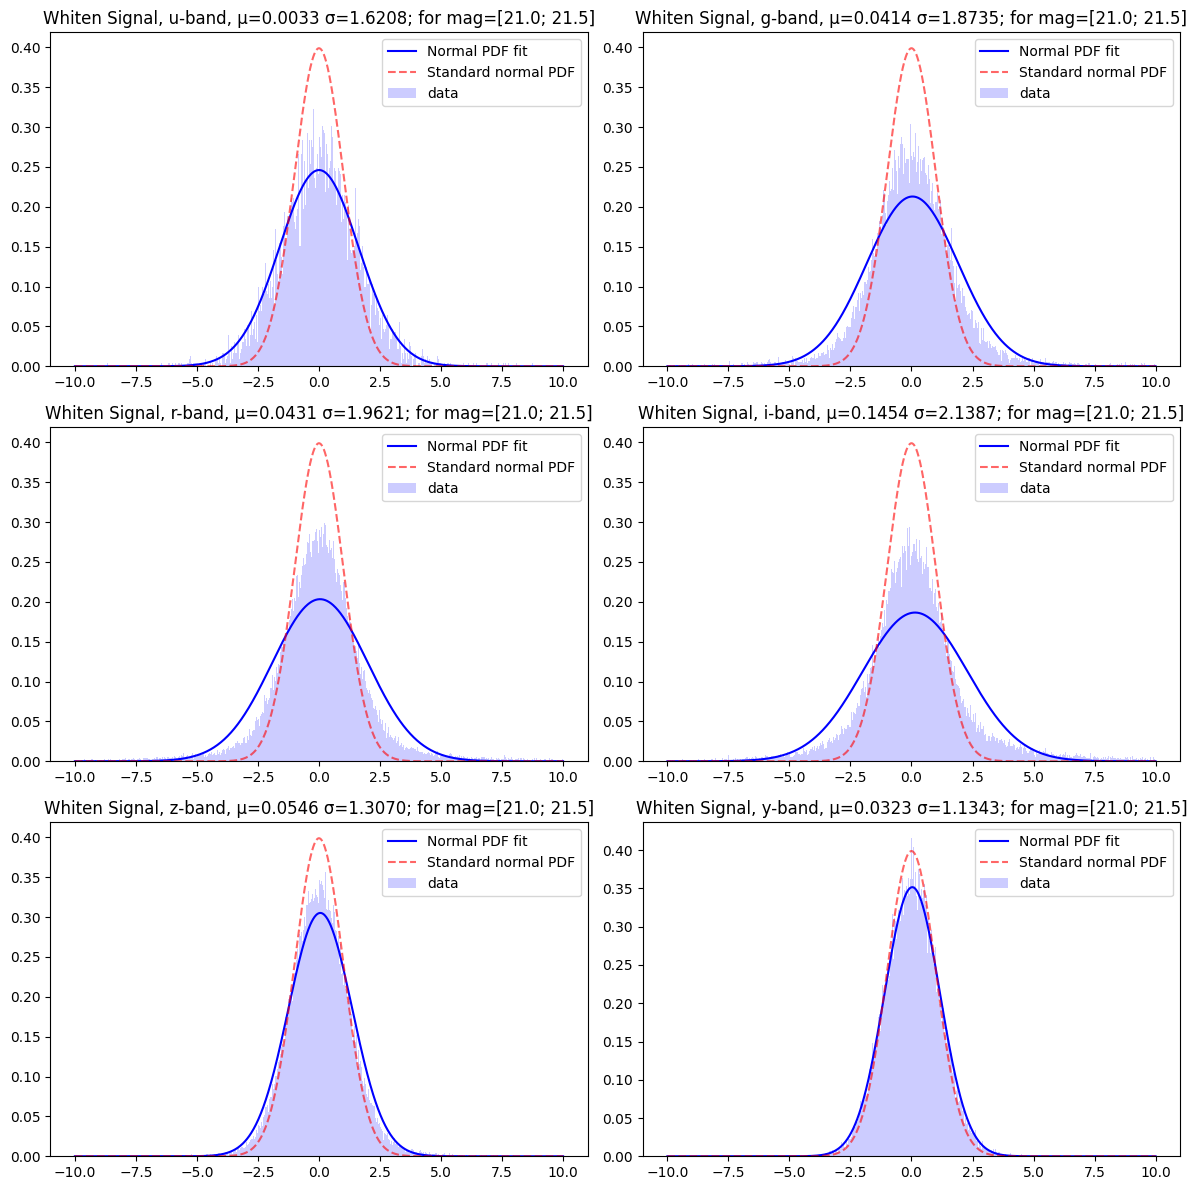

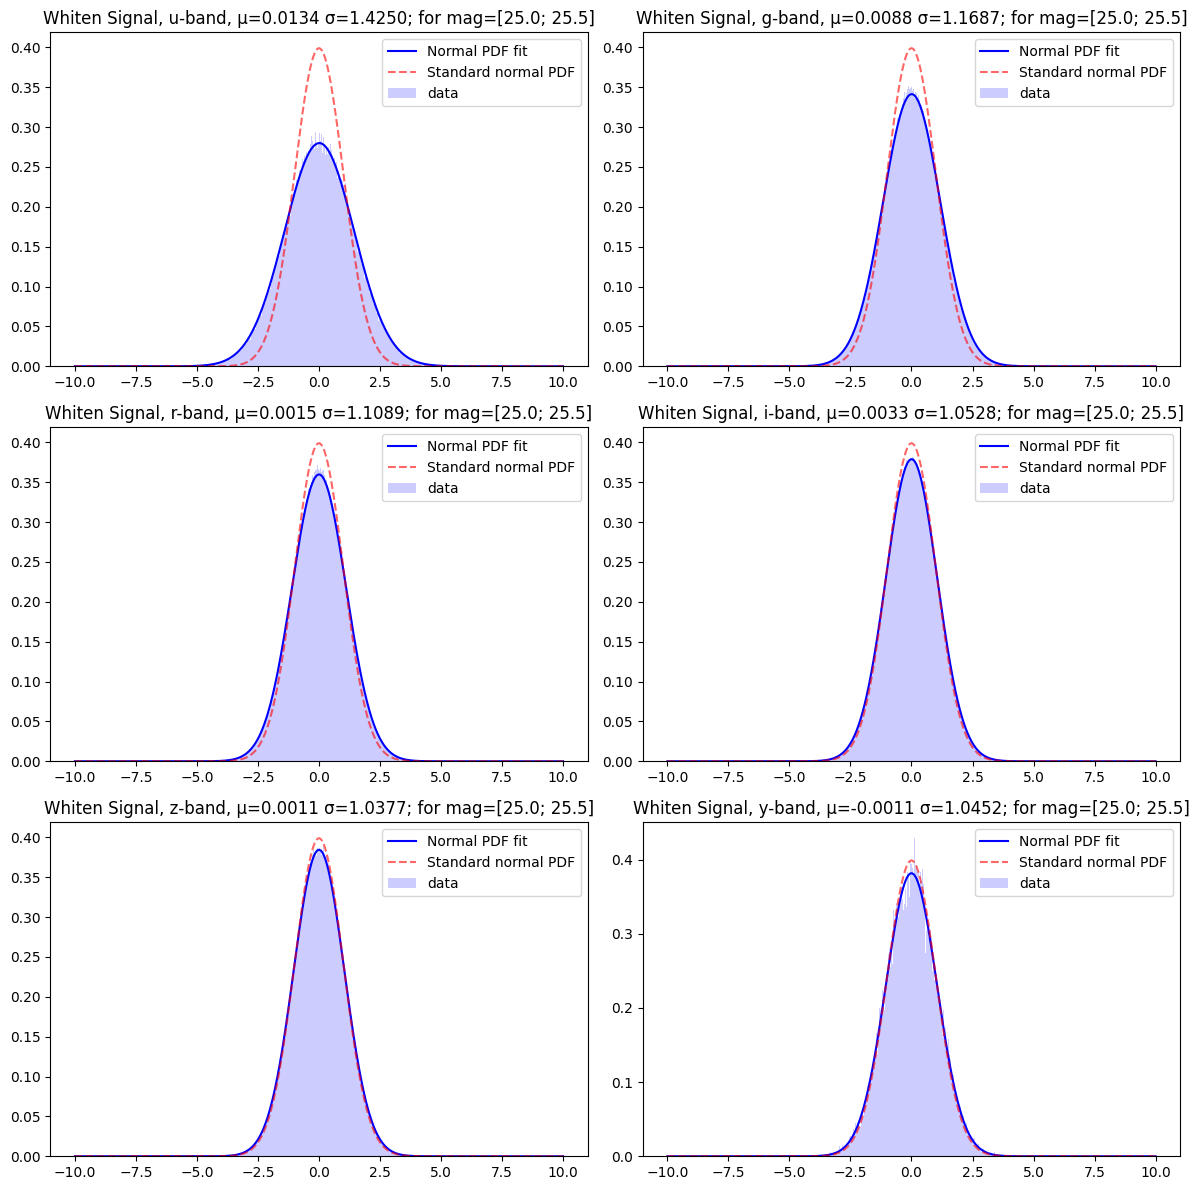

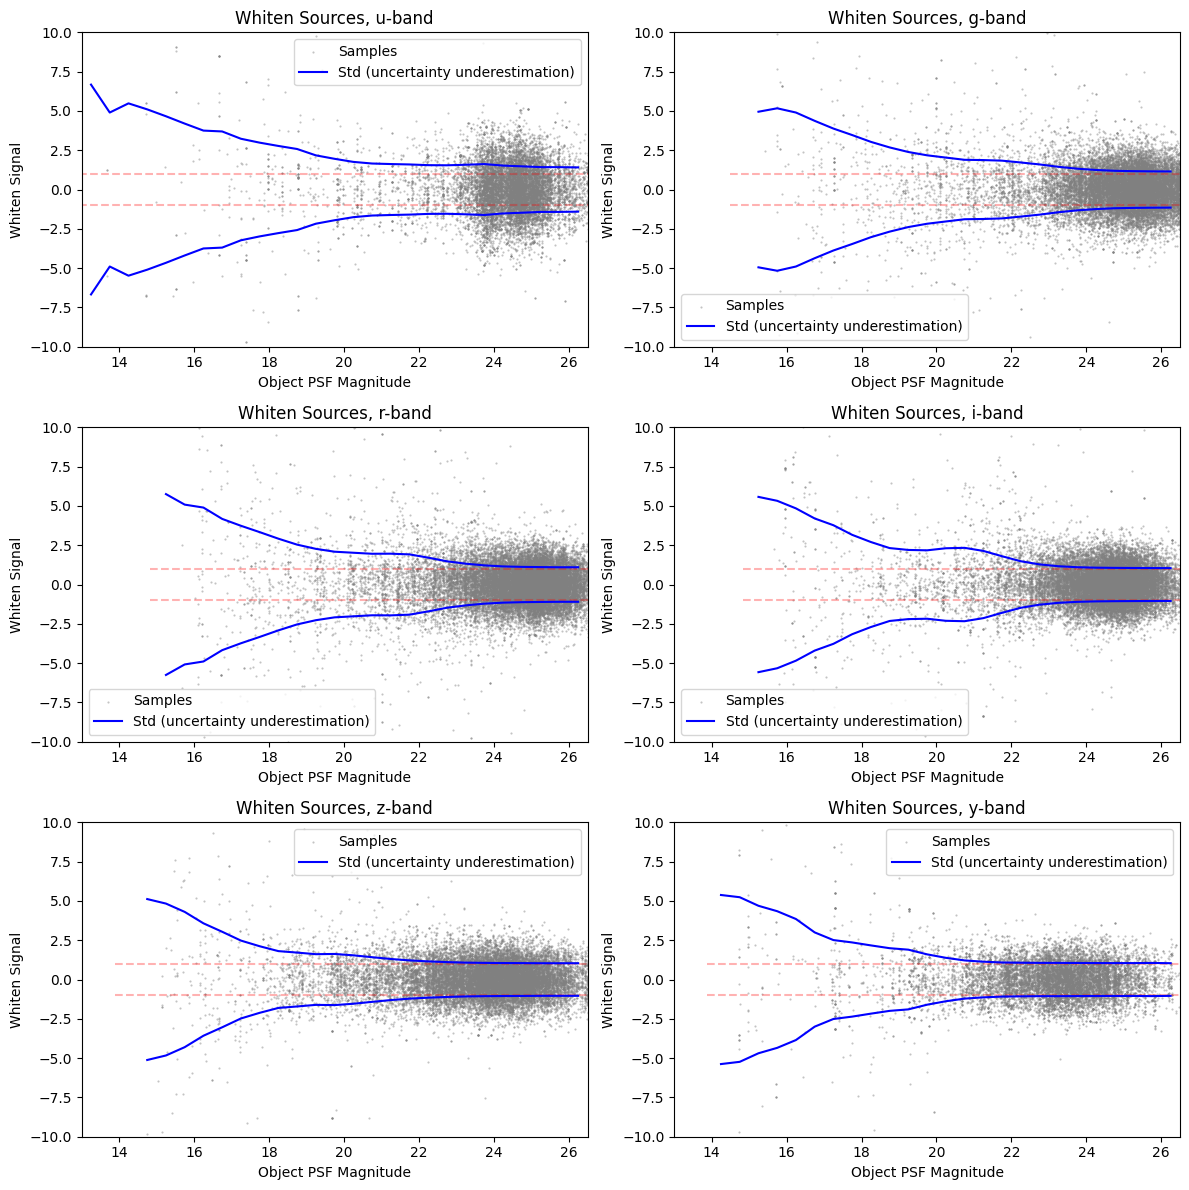

In [2]:
from uncle_val.pipelines import make_plots

make_plots(
    dp1_root=DP1_ROOT,
    test_only=PLOT_ON_TEST_SET,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=None,
    n_samples=5,
    object_mags=[18, 21, 25],
)

In [3]:
# %load_ext tensorboard
# %tensorboard --logdir=runs

In [4]:
from functools import partial

from uncle_val.learning.losses import kl_divergence_whiten
from uncle_val.pipelines import run_dp1_mlp

model_path, model_columns = run_dp1_mlp(
    dp1_root=DP1_ROOT,
    n_workers=LSDB_WORKERS,
    n_src=N_SRC,
    n_lcs=N_LCS,
    loss_fn=None,  # partial(kl_divergence_whiten, soft=20),
    train_batch_size=BATCH_SIZE,
    start_tfboard=True,
    output_root="./runs",
    device=DEVICE,
)

Tensorboard Link: http://localhost:6006/
Dask Dashboard Link: http://127.0.0.1:8787/status


Validation batches:   0%|          | 0/244 [00:00<?, ?it/s]

In [5]:
print(model_path)
print(model_columns)

runs/2025-10-11_10-49/mlp.pt
['lc.x', 'lc.err', 'extendedness', 'is_u_band', 'is_g_band', 'is_r_band', 'is_i_band', 'is_z_band', 'is_y_band']


Dask Dashboard Link: http://127.0.0.1:8787/status


/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'C', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'F', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  decomposed = _stable_decomposition(v, np=np)
/Users/hombit/projects/lincc-frameworks/uncle-val/src/uncle_val/whitening.py:64: NumbaPerformanceWarning: '@' is faster on contigu

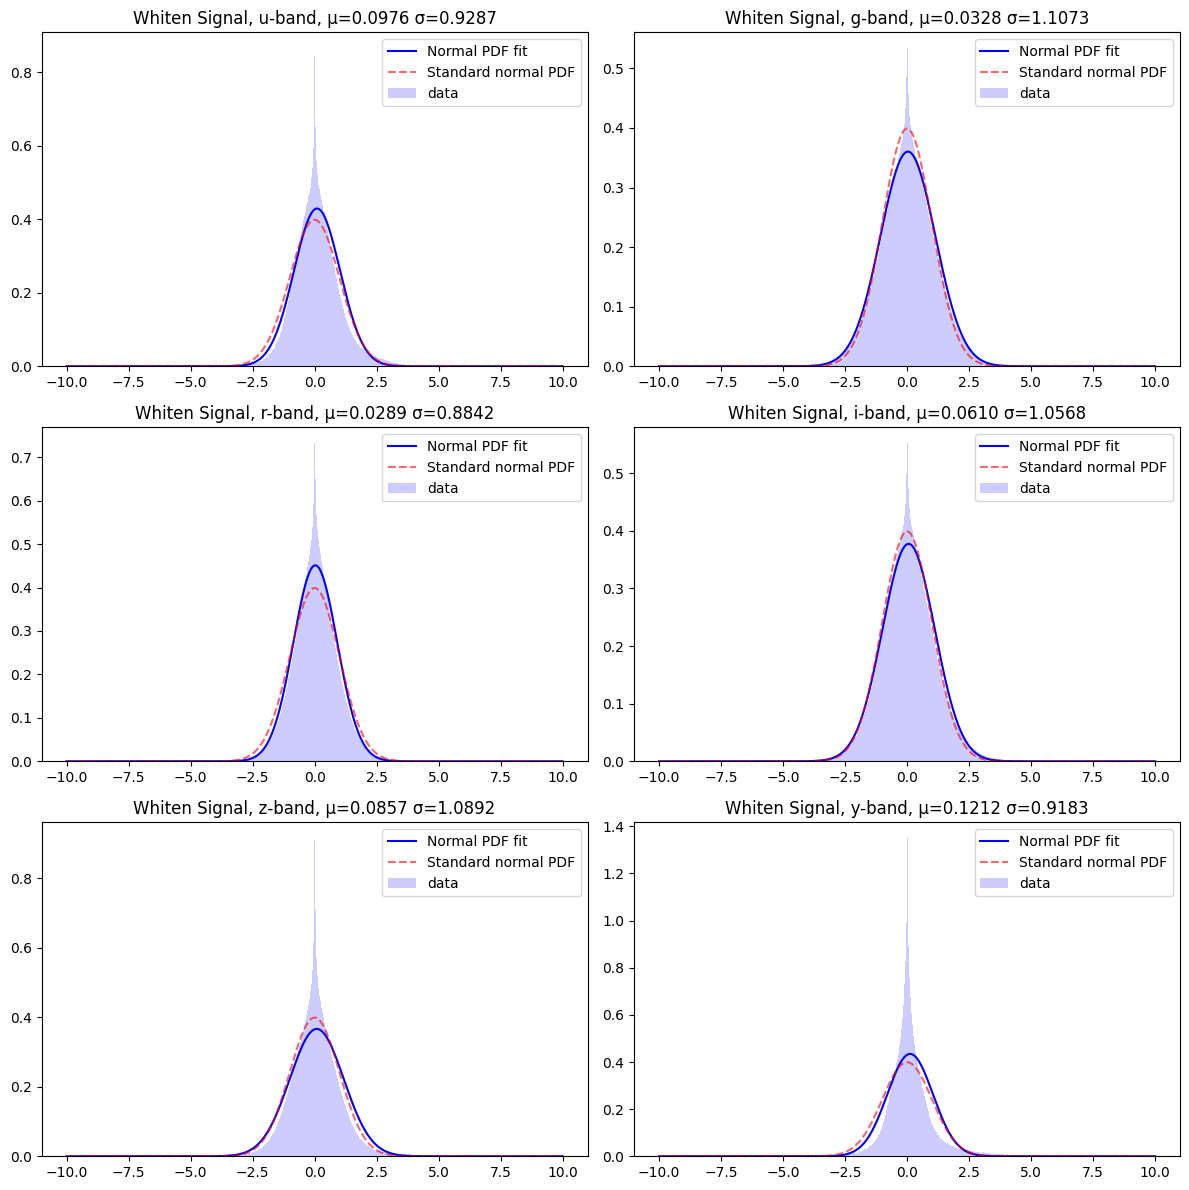

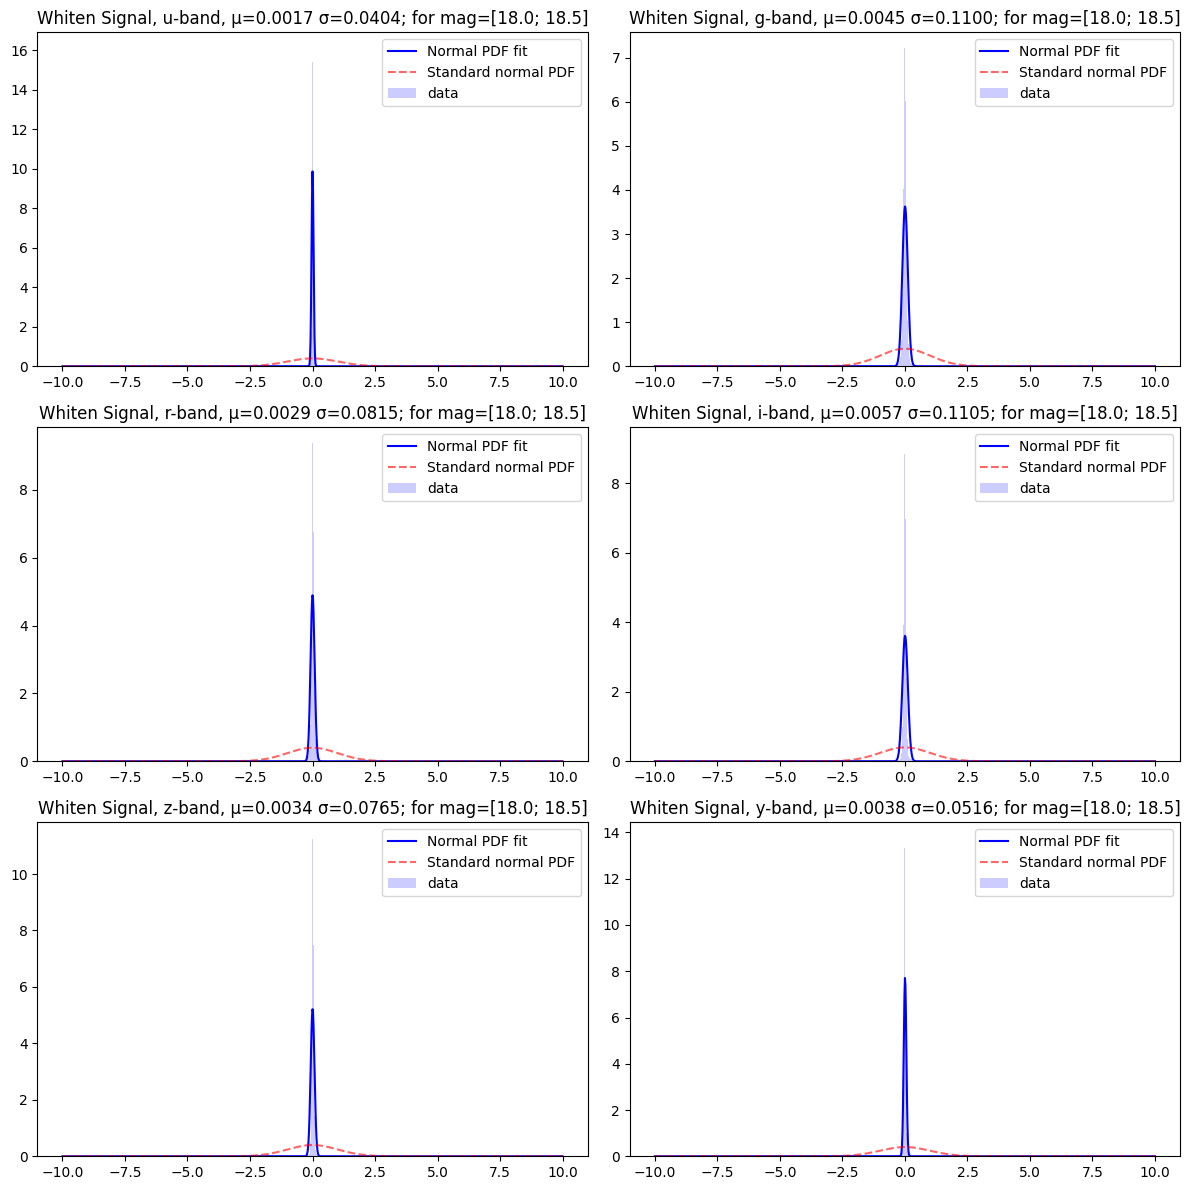

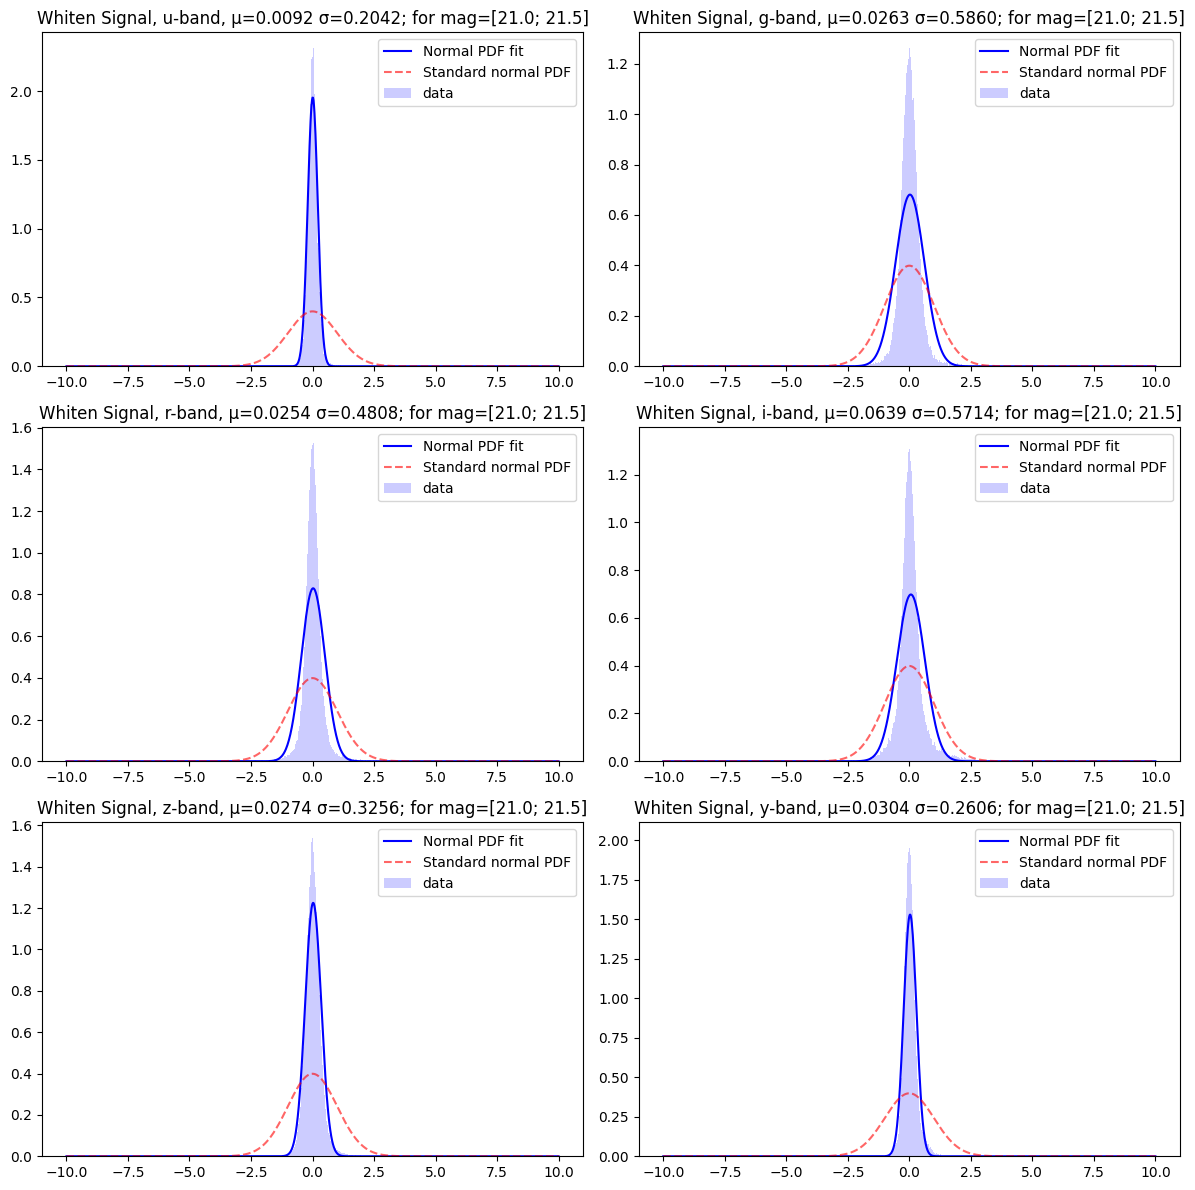

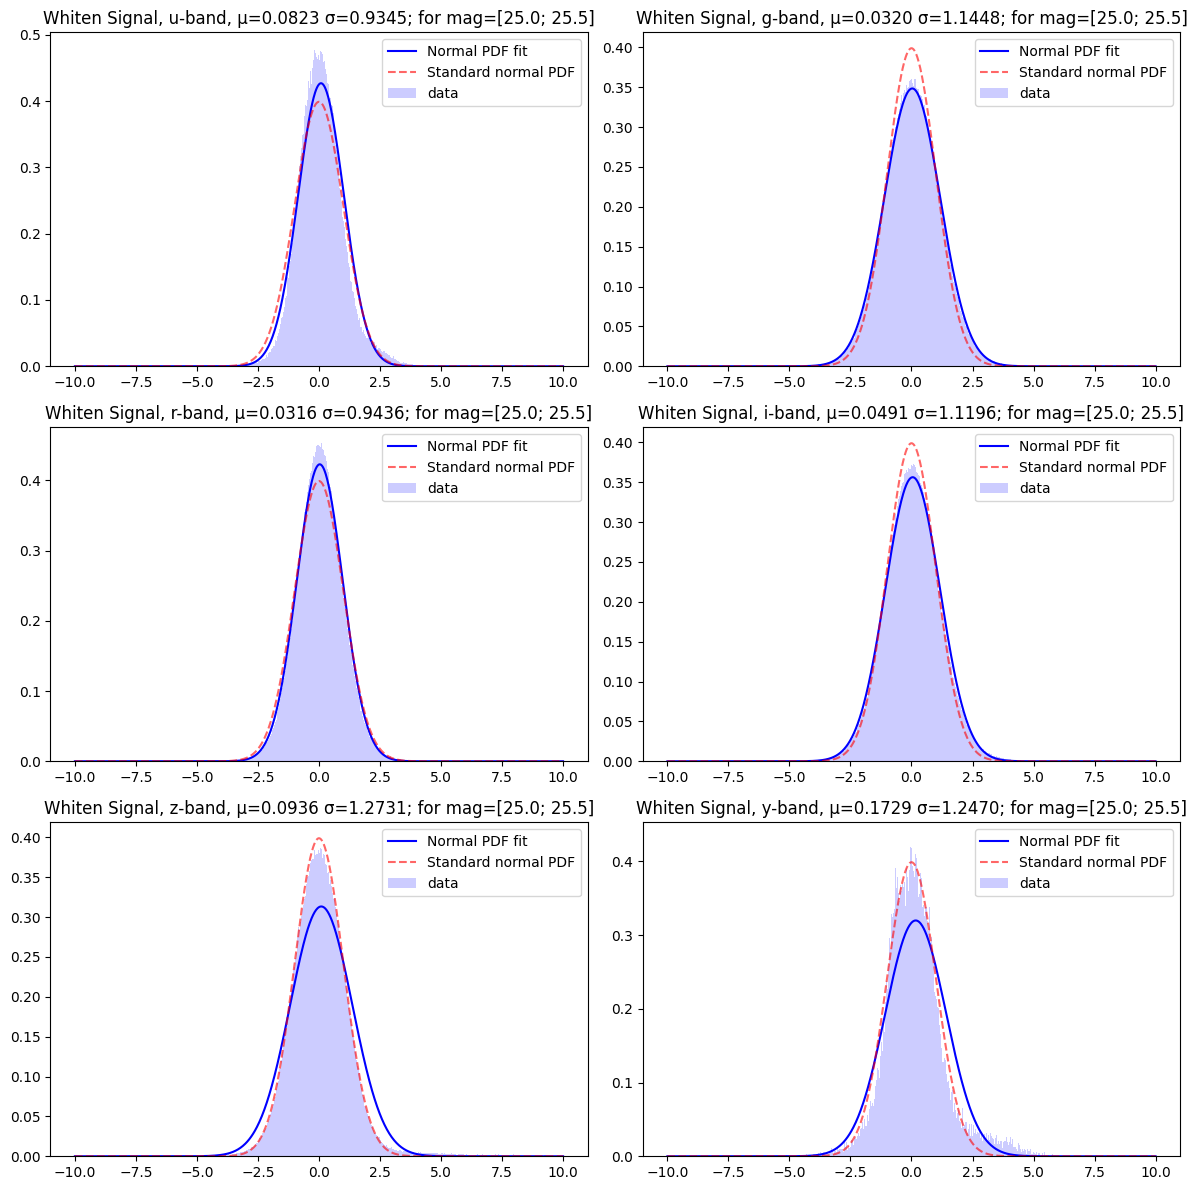

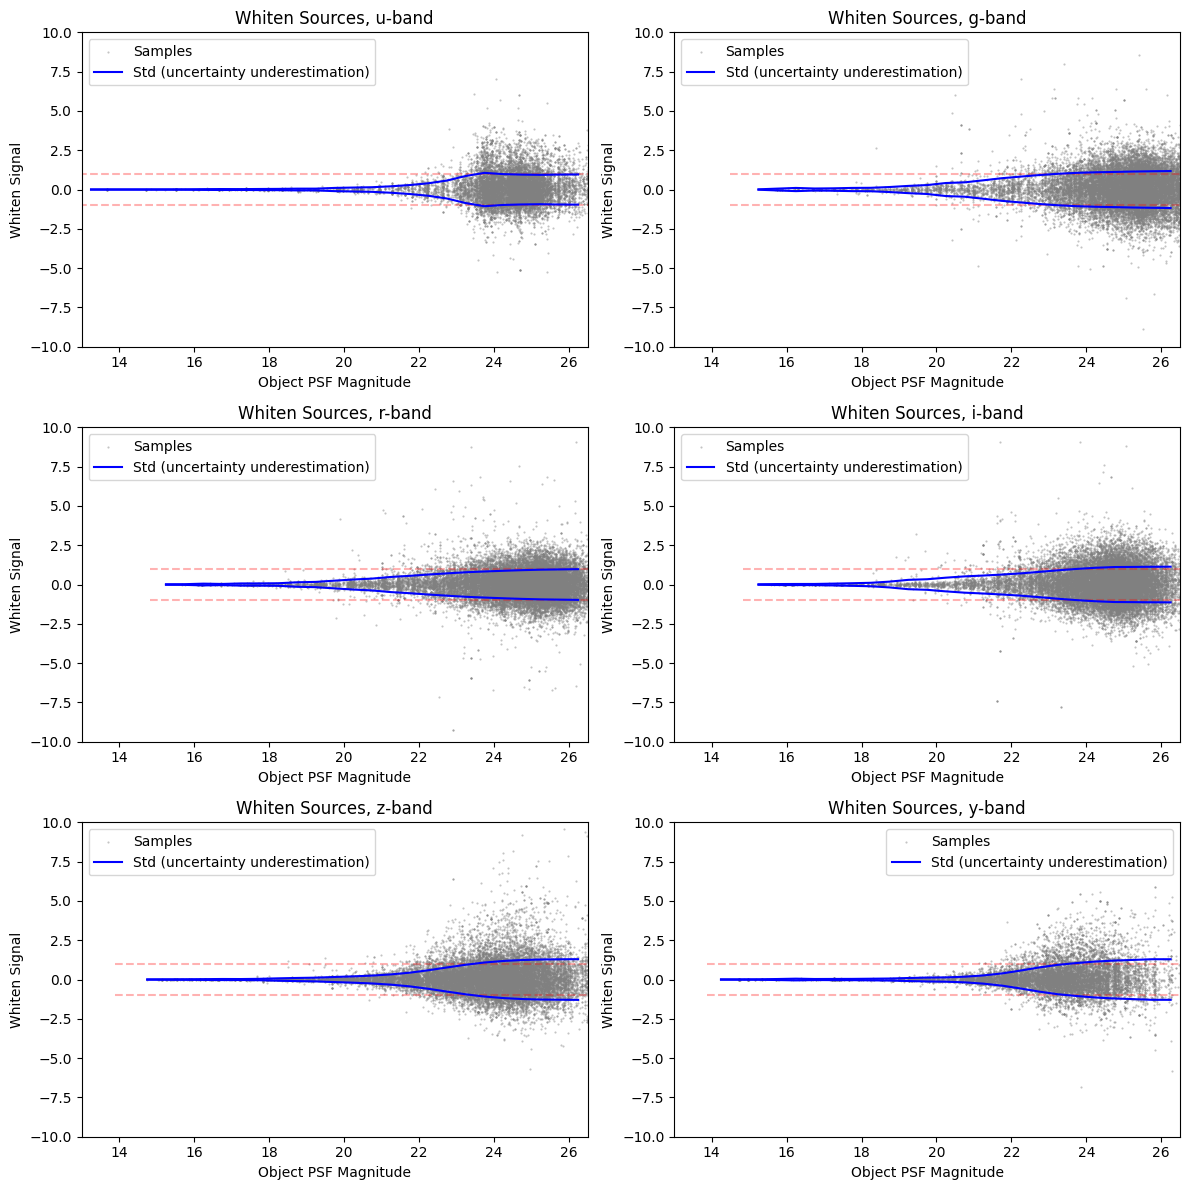

In [6]:
from uncle_val.pipelines import make_plots

make_plots(
    dp1_root=DP1_ROOT,
    test_only=PLOT_ON_TEST_SET,
    min_n_src=N_SRC,
    non_extended_only=False,
    n_workers=LSDB_WORKERS,
    model_path=model_path,
    model_columns=model_columns,
    # model_path="runs/2025-10-10_20-39/mlp.pt",
    # model_columns=['lc.x', 'lc.err', 'extendedness', 'is_u_band', 'is_g_band', 'is_r_band', 'is_i_band', 'is_z_band', 'is_y_band'],
    device=DEVICE,
    n_samples=5,
    object_mags=[18, 21, 25],
)